In [1]:
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time

In [23]:
# def show(img):
#     io.imshow(img)
#     plt.show()

In [28]:
og_images=[]
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    og_images.append(img)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
          features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
#     class_weight = {
#         0: (807 / (4 * 140)),
#         1: (807 / (4 * 140)),
#         2: (807 / (4 * 133)),
#         3: (807 / (4 * 70))
#     }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["daisy", "dandelion", "roses", "sunflowers" ,"tulips"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

In [8]:
import os
import numpy as np
import shutil
import pandas as pd


def train_test_split():

    root_dir = "flowers dataset"
    classes_dir = ["daisy", "dandelion", "roses", "sunflowers" ,"tulips"]
    processed_dir = 'flower_photos'

    
    test_ratio = 0.20

    for cls in classes_dir:
        # Creating partitions of the data after shuffeling
        print(" Class Name " + cls + ": ")
        # Folder to copy images from
        src = processed_dir +"//" + cls  

        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames) * (1 - (test_ratio)))])

        train_FileNames = [src + '//' + name for name in train_FileNames.tolist()]
        test_FileNames = [src + '//' + name for name in test_FileNames.tolist()]

        print('Total images: '+ str(len(allFileNames)))
        print('Training: '+ str(len(train_FileNames)))
        print('Testing: '+ str(len(test_FileNames)))

        os.makedirs(root_dir + '/train//' + cls)
        os.makedirs(root_dir + '/test//' + cls)

        # Copy-pasting images
        for name in train_FileNames:
            shutil.copy(name, root_dir + '/train//' + cls)

        for name in test_FileNames:
            shutil.copy(name, root_dir + '/test//' + cls)

train_test_split()

 Class Name daisy: 
Total images: 633
Training: 506
Testing: 127
 Class Name dandelion: 
Total images: 898
Training: 718
Testing: 180
 Class Name roses: 
Total images: 641
Training: 512
Testing: 129
 Class Name sunflowers: 
Total images: 699
Training: 559
Testing: 140
 Class Name tulips: 
Total images: 799
Training: 639
Testing: 160


In [29]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    print("Train images path detected.")
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 5
    image_count = len(images)

    for img_path in images:
        if("daisy" in img_path):
            class_index = 0
        elif("dandelion" in img_path):
            class_index = 1
        elif("roses" in img_path):
            class_index = 2
        elif("sunflowers" in img_path):
            class_index = 3    
        else:
               class_index = 4

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


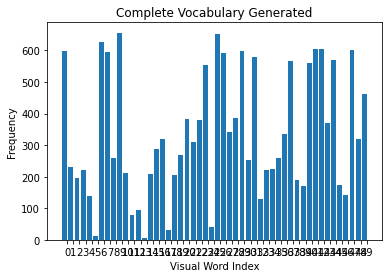

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
--- 1833.4380791187286 seconds ---


In [30]:
train_path = "flowers dataset/train"
test_path = "flowers dataset/test"
no_clusters = 50
kernel = "precomputed"

start_time = time.time()
kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))


In [35]:
from sklearn.metrics import classification_report,accuracy_score

def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "daisy",
        "1": "dandelion",
        "2": "roses",
        "3": "sunflowers",
        "4": "tulips"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("daisy" in img_path):
                true.append("daisy")
            elif("dandelion" in img_path):
                true.append("dandelion")
            elif("roses" in img_path):
                true.append("roses")
            elif("sunflowers" in img_path):
                true.append("sunflowers")    
            else:
                true.append("tulips")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    
    print(classification_report(true, predictions))
    print("Execution done.")
    right = []
    wrong = []
    
    for i in range (25):
        if true[i] != predictions[i]:
            wrong.append(i)
        else:
            right.append(i)

    for img in right:
        print("Correctly classified:")
        plt.imshow(og_images[img])
        plt.show()

    for img in wrong:
        print("Incorrectly classified:")
        plt.imshow(og_images[img])
        plt.show()

Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[ 64  23  10  18  12]
 [ 14 119   6  15  26]
 [  8  19  46  12  44]
 [ 17  14  11  82  16]
 [ 18  35  11  21  75]]
Normalized confusion matrix
[[0.5  0.18 0.08 0.14 0.09]
 [0.08 0.66 0.03 0.08 0.14]
 [0.06 0.15 0.36 0.09 0.34]
 [0.12 0.1  0.08 0.59 0.11]
 [0.11 0.22 0.07 0.13 0.47]]


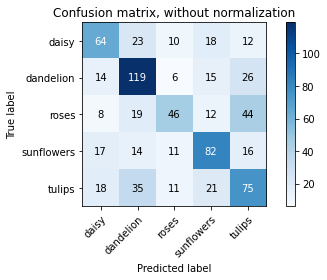

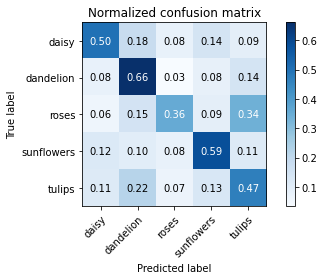

Confusion matrixes plotted.
accuracy score: 0.524
Accuracy calculated.
              precision    recall  f1-score   support

       daisy       0.53      0.50      0.52       127
   dandelion       0.57      0.66      0.61       180
       roses       0.55      0.36      0.43       129
  sunflowers       0.55      0.59      0.57       140
      tulips       0.43      0.47      0.45       160

    accuracy                           0.52       736
   macro avg       0.53      0.52      0.52       736
weighted avg       0.53      0.52      0.52       736

Execution done.
Correctly classified:


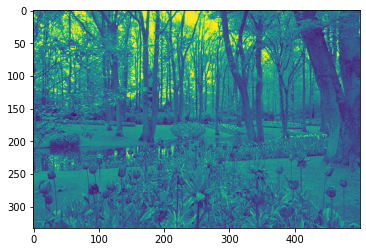

Correctly classified:


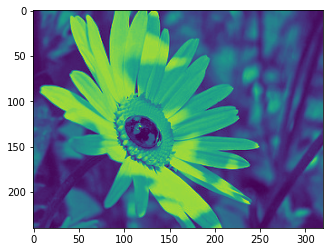

Correctly classified:


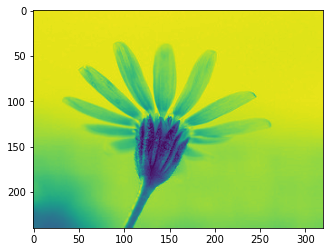

Correctly classified:


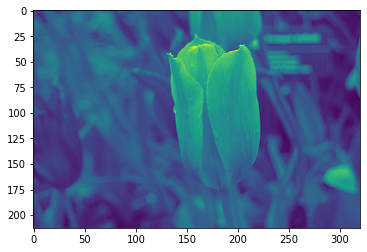

Correctly classified:


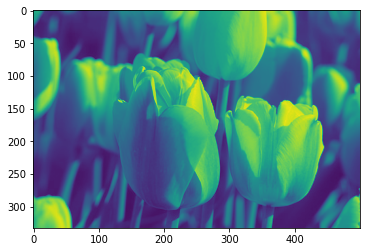

Correctly classified:


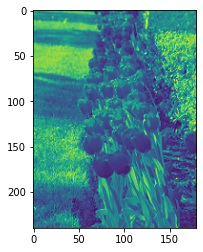

Correctly classified:


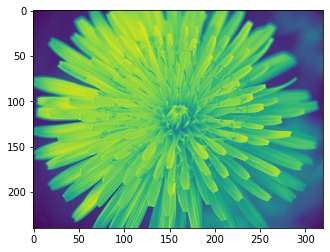

Correctly classified:


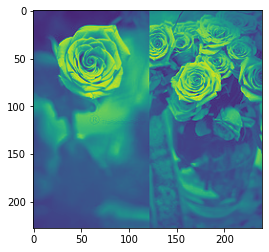

Correctly classified:


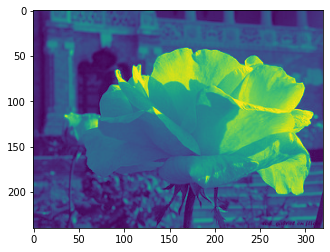

Correctly classified:


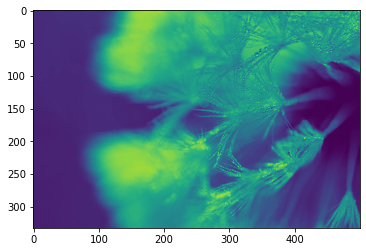

Correctly classified:


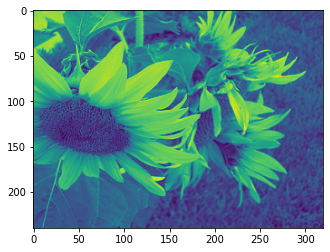

Correctly classified:


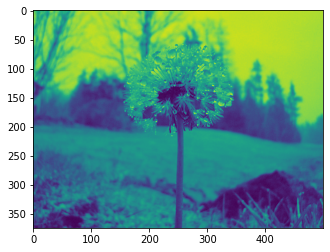

Correctly classified:


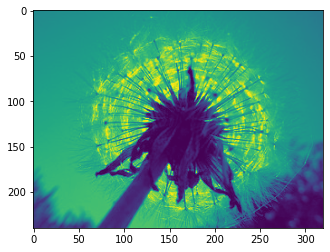

Correctly classified:


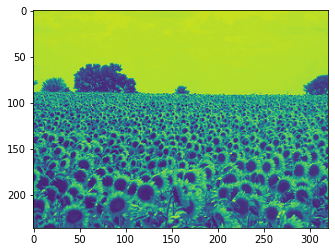

Correctly classified:


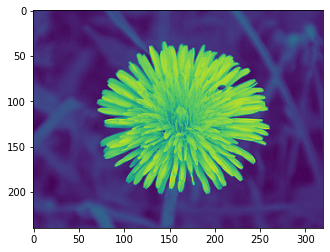

Correctly classified:


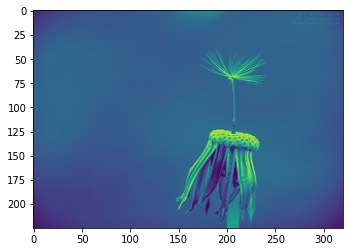

Incorrectly classified:


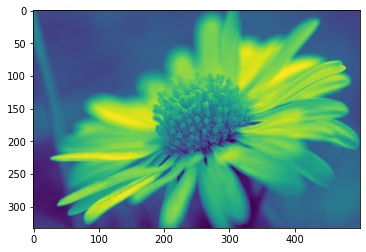

Incorrectly classified:


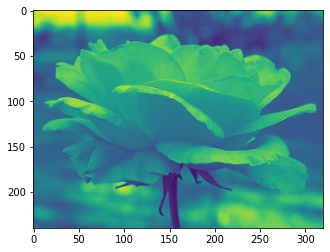

Incorrectly classified:


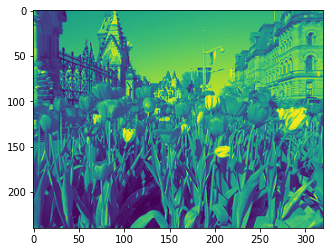

Incorrectly classified:


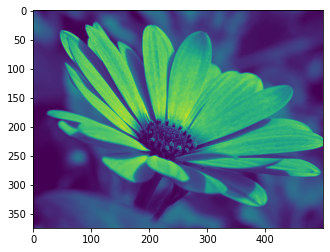

Incorrectly classified:


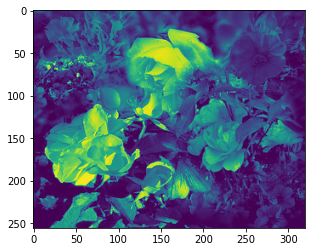

Incorrectly classified:


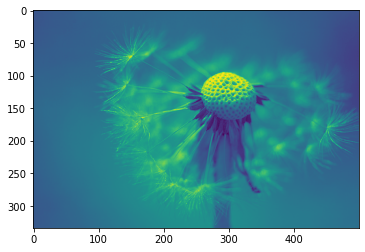

Incorrectly classified:


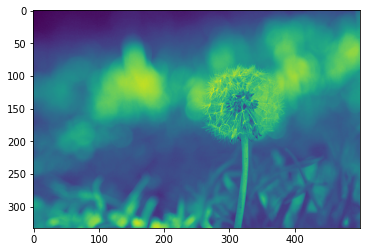

Incorrectly classified:


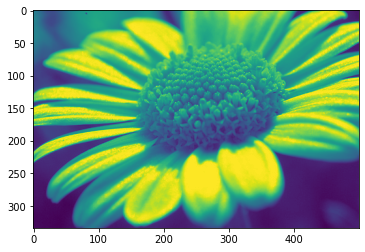

Incorrectly classified:


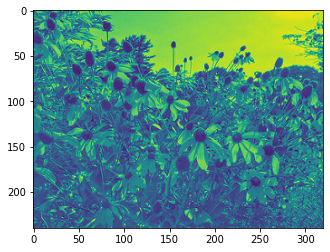

--- 133.72994661331177 seconds ---


In [36]:
start_time = time.time()
testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
print("--- %s seconds ---" % (time.time() - start_time))